# Data Analysis using XGBoost
We are going to use boosted trees. The question is: why don't we use the gradient boosted in Spark?

THe reason is that, in our experience, XGBoost running on a single machine is much faster than Spark running on 10 machines. So we use XGBoost and am showing you how to use it here.

## Importing Required Libraries

In [22]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh

Populating the interactive namespace from numpy and matplotlib


In [23]:
from lib.logger import logger

## Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](Data_Processing_Whales.ipynb). The preprocessed is a numpy array with `4175` rows (for the 10mb file) with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [24]:
#Use Data/processed_data_150mb.np for a slightly bigger file
data  = np.load("Data/processed_data_15mb.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)
X.shape

(4175, 12)

## Partitioning the data

The data is shuffled and divided as follow:

* **85%** of the data is used to perform bootstrap analysis of training variability. This data is partitioned into training and validation many times to produce many validation-set predictions for each example
   * **70% Training:**   Used to train the model
   * **15% Validation:** Used to evaluate the model
   


* **15%** of the data is held-out for final testing.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training and Feature Visualization

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Evaluation Criterion= Maximize Loglikelihood according to the logistic regression _(logitboost)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

In [26]:
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 0     # not silent
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss' #['error','logloss']

plst = param.items()
print(param)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


In [83]:
# %load lib/Logger.py
import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst100 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self):
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        df.plot(grid=True,title=title)  
        return df


## Training the model

Note: Running XGBoost for 1000 iterations **On the full data** takes about 70-80 minutes to train. Use **verbose_eval=True** to track number of iterations complete.

In [84]:
def test_xgboost(depth=4,num_round=100):
    param['max_depth']= depth   # depth of tree
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()
        param['eval_metric'] = _eval 
        bst100 = xgb.train(param.items(), dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log()
        

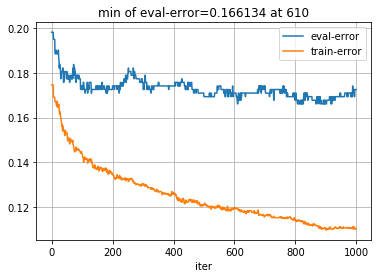

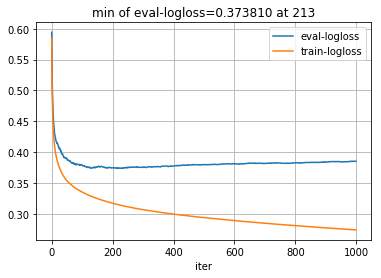

In [85]:
test_xgboost(depth=1,num_round=1000)

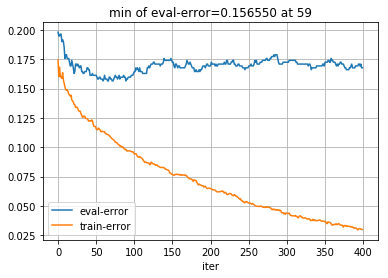

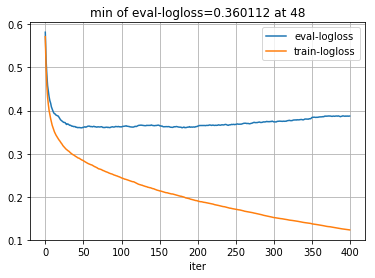

In [87]:
test_xgboost(depth=2,num_round=400)

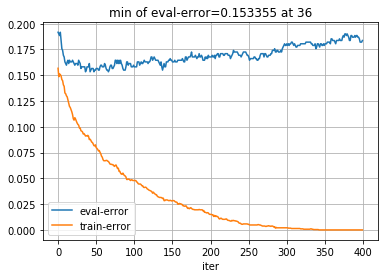

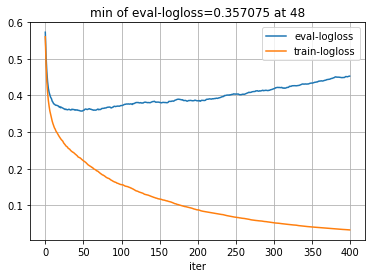

In [88]:
test_xgboost(depth=3,num_round=400)

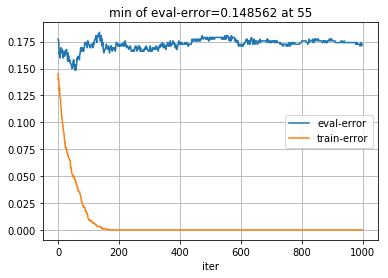

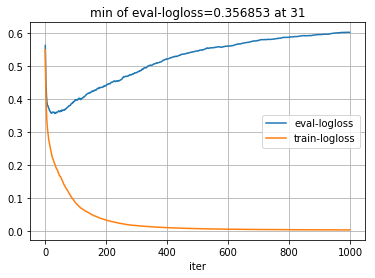

In [89]:
test_xgboost(depth=4,num_round=1000)

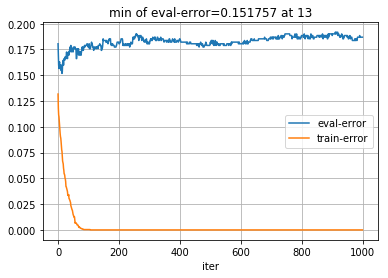

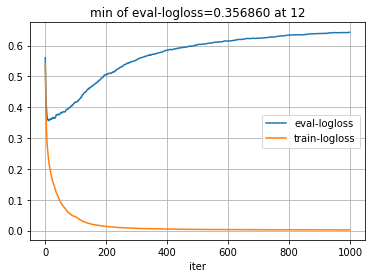

In [90]:
test_xgboost(depth=5,num_round=1000)

## Visualize the Feature Importance

In [6]:
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

100 Iterations


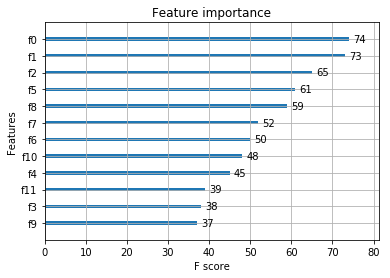

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [7]:
print("100 Iterations")
xgbh.visualize_features(bst100, features_map)

1000 Iterations


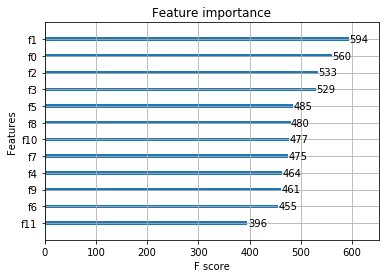

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [8]:
print("1000 Iterations")
xgbh.visualize_features(bst1000, features_map)

# Margin Plots on Test Data

In [9]:
y_pred_100 = bst100.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [10]:
# #Uncomment this part if you want to load directly from the pickle file instead of running XGBoost for 1000 iterations on the entire data.
# #Processed pickle file (xgboost_output_full_data.pk) has been provided. 
# import pickle

# #Processed output after running them on a model
# p = pickle.load(open('Data/xgboost_output_full_data.pk', 'rb'))

# y_test = np.array(p['y_test'], dtype = int)
# y_pred_100 = p['y_pred_100']
# y_pred_1000 = p['y_pred_1000']

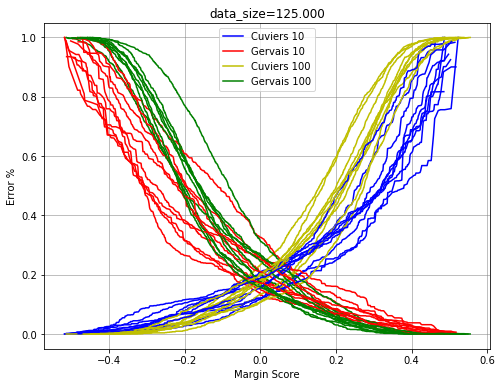

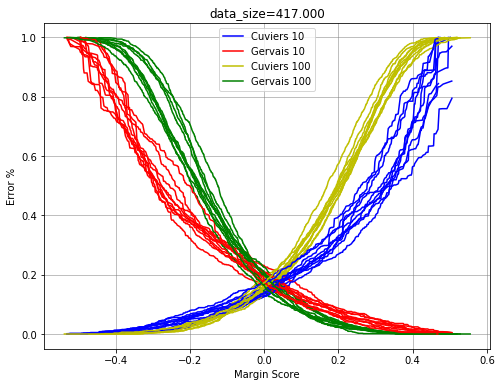

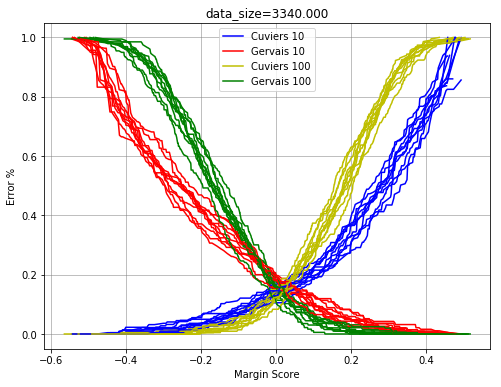

In [11]:
for _train_size in [0.03,0.1,0.8]:
    plt.figure(figsize=(8, 6))
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=_train_size,test_size=1-_train_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        legends=[]
        # Use early_stopping_rounds=5 to enable early stopping
        for num_round in [10,100]:
            bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)
            y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(X_train.shape[0]))
    plt.show()

## Per example variation analysis
The CDFs provide information on the variation of the aggregate. If we want to estimate of the confidence on a single examples we need to compute the variance **per example**

In [12]:
data  = np.load("Data/processed_data_15mb.np")
data.shape

(4175, 13)

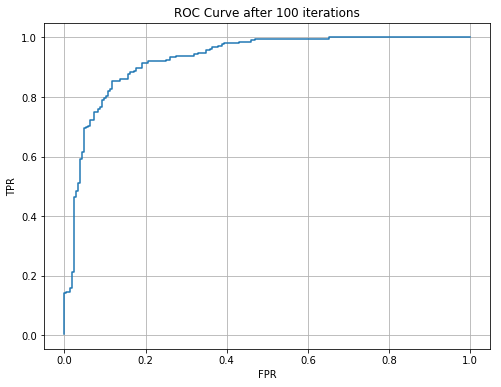

In [13]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#plt.plot(fpr, tpr)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve after 100 iterations")
plt.grid()
plt.show()


In [14]:
def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger

In [15]:
def generate_samples(data, size=500, num_chunks=20):
    for i in range(200):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, ntree_limit=bst.best_ntree_limit, output_margin=True)

        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp)
        
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]         
    
    for i in range(20):
        plt.plot([min_cuv[i], max_cuv[i]], [i/20.0, i/20.0], 'b')
        plt.plot([min_ger[i], max_ger[i]], [i/20.0, i/20.0], 'r')
    

Thresholds (lower, upper): -0.09556603 0.14900206


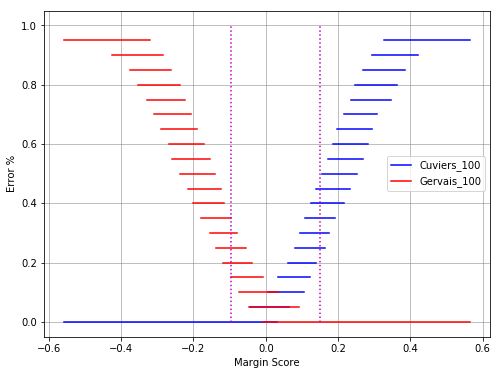

In [16]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']

#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20)

#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Margin Score')
plt.ylabel('Error %')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()